# Bitcoin Monitor Pipeline Project

Credit to @josephmachado for project concept

For this project, we will pull bitcoin exchange data from [CoinCap API](https://docs.coincap.io/). We will pull this data every 5 minutes and load it into our warehouse.

We use python to pull, transform and load data. Our warehouse is Postgres. We also spin up a Metabase instance for our presentation layer.

All of the components are running as docker containers and will be deployed to EC2.

![Pipeline](https://www.startdataengineering.com/images/bc_monitor/bc_arch.png)

## Prerequisites

1. [Docker](https://docs.docker.com/engine/install/) and [Docker Compose](https://docs.docker.com/compose/install/) v1.27.0 or later.
2. [AWS account](https://aws.amazon.com/)
3. [AWS CLI installed](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2.html) and [configured](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html)

## ETL Code

The code to pull data from [CoinCap API](https://docs.coincap.io/) and load it into our warehouse is at `exchange_data_etl.py`. In this script we

1. Pull data from [CoinCap API](https://docs.coincap.io/) using the `get_exchange_data` function.
2. Use `get_utc_from_unix_time` function to get UTC based date time from unix time(in ms).
3. Load data into our warehouse using the `_get_exchange_insert_query` insert query.

```python
def run() -> None:
    data = get_exchange_data()
    for d in data:
        d['update_dt'] = get_utc_from_unix_time(d.get('updated'))
    with WarehouseConnection(**get_warehouse_creds()).managed_cursor() as curr:
        p.execute_batch(curr, _get_exchange_insert_query(), data)
```

There are a few things going on at `“with WarehouseConnection(**get_warehouse_creds()).managed_cursor() as curr:"`.

1. We use the `get_warehouse_creds` utility function to get the warehouse connection credentials.
2. The warehouse connection credentials are stored as environment variables within our docker compose definition. The `docker-compose` uses the hardcoded values from the `env` file.
3. The credentials are passed as `**kwargs` to the `WarehouseConnection` class.
4. The `WarehouseConnection` class uses contextmanager to enable opening and closing the DB connections easier. This lets us access the DB connection without having to write boilerplate code.

```python
def get_warehouse_creds() -> Dict[str, Optional[Union[str, int]]]:
    return {
        'user': os.getenv('WAREHOUSE_USER'),
        'password': os.getenv('WAREHOUSE_PASSWORD'),
        'db': os.getenv('WAREHOUSE_DB'),
        'host': os.getenv('WAREHOUSE_HOST'),
        'port': int(os.getenv('WAREHOUSE_PORT', 5432)),
    }
```

```python
class WarehouseConnection:
    def __init__(
        self, db: str, user: str, password: str, host: str, port: int
    ):
        self.conn_url = f'postgresql://{user}:{password}@{host}:{port}/{db}'

    @contextmanager
    def managed_cursor(self, cursor_factory=None):
        self.conn = psycopg2.connect(self.conn_url)
        self.conn.autocommit = True
        self.curr = self.conn.cursor(cursor_factory=cursor_factory)
        try:
            yield self.curr
        finally:
            self.curr.close()
            self.conn.close()
```

## Test

We will add 2 major types of tests:

1. Unit test: To test if individual functions are working as expected. We test `get_utc_from_unix_time` with the `test_get_utc_from_unix_time` function.
2. Integration test: To test if multiple systems work together as expected.

For the integration test we:

1. Mock the Coinbase API call using the `mocker` functionality of the `pytest-mock` library. We use fixture data at `test/fixtures/sample_raw_exchange_data.csv` as a result of an API call. This is to enable deterministic testing.
2. Assert that the data we store in the warehouse is the same as we expected.
3. Finally the `teardown_method` truncates the local warehouse table. This is automatically called by pytest after the `test_covid_stats_etl_run` test function is run.

```python
class TestBitcoinMonitor:
    def teardown_method(self, test_covid_stats_etl_run):
        with WarehouseConnection(
            **get_warehouse_creds()
        ).managed_cursor() as curr:
            curr.execute("TRUNCATE TABLE bitcoin.exchange;")

    def get_exchange_data(self):
        with WarehouseConnection(**get_warehouse_creds()).managed_cursor(
            cursor_factory=psycopg2.extras.DictCursor
        ) as curr:
            curr.execute(
                '''SELECT id,
                        name,
                        rank,
                        percenttotalvolume,
                        volumeusd,
                        tradingpairs,
                        socket,
                        exchangeurl,
                        updated_unix_millis,
                        updated_utc
                        FROM bitcoin.exchange;'''
            )
            table_data = [dict(r) for r in curr.fetchall()]
        return table_data

    def test_covid_stats_etl_run(self, mocker):
        mocker.patch(
            'bitcoinmonitor.exchange_data_etl.get_exchange_data',
            return_value=[
                r
                for r in csv.DictReader(
                    open('test/fixtures/sample_raw_exchange_data.csv')
                )
            ],
        )
        run()
        expected_result = [
          {"see github repo for full data"}
        ]
        result = self.get_exchange_data()
        assert expected_result == result
```

Run tests using:
```bash
make up # to start all your containers 
make pytest
```

## Scheduler

Now that we have the ETL script and tests setup, we need to schedule the ETL script to run every 5 minutes. Since this is a simple script we will go with `cron` instead of setting up a framework like Airflow or Dagster. The cron job is defined at `scheduler/pull_bitcoin_exchange_info`:

```bash
SHELL=/bin/bash
HOME=/
*/5 * * * * WAREHOUSE_USER=sdeuser WAREHOUSE_PASSWORD=sdepassword1234 WAREHOUSE_DB=finance WAREHOUSE_HOST=warehouse WAREHOUSE_PORT=5432  PYTHONPATH=/code/src /usr/local/bin/python /code/src/bitcoinmonitor/exchange_data_etl.py
```

This file is placed inside the `pipelinerunner` docker container’s `crontab` location. We have hardcoded the environment variables.

## Presentation

Now that we have the code and scheduler set up, we can add checks and formatting automation to ensure that we follow best practices.

### Formatting, Linting, and Type checks
Formatting enables us to stay consistent with the code format. We use black and isort to automate formatting. The `-S` black module flag ensures that we use single quotes for strings (following PEP8).

Linting analyzes the code for potential errors and ensures that the code formatting is consistent. We use `flake8` to lint check our code.

Type checking enables us to catch type errors (when defined). We use `mypy` for this.

All of these are run within the docker container. We use a `Makefile` to store shortcuts to run these commands.

Automatically format and test the code:
```bash
make ci # this command will format your code, run lint and type checks and run all your tests 
```

## Live Dashboard

We have a [`Makefile`](Makefile) with common commands. These are executed in the running container.

We can spin up a dashboard locally using:
```bash
make up # starts all the containers
make ci # runs formatting, lint check, type check and python test
```

Then visit [http://localhost:3000](http://localhost:3000) to log into the local Metabase instance. From the Metabase UI, you can add charts and dashboards. 

You can connect to the warehouse with the following credentials:
```bash
Host: warehouse
Database name: finance
```

Some sample visualizations:
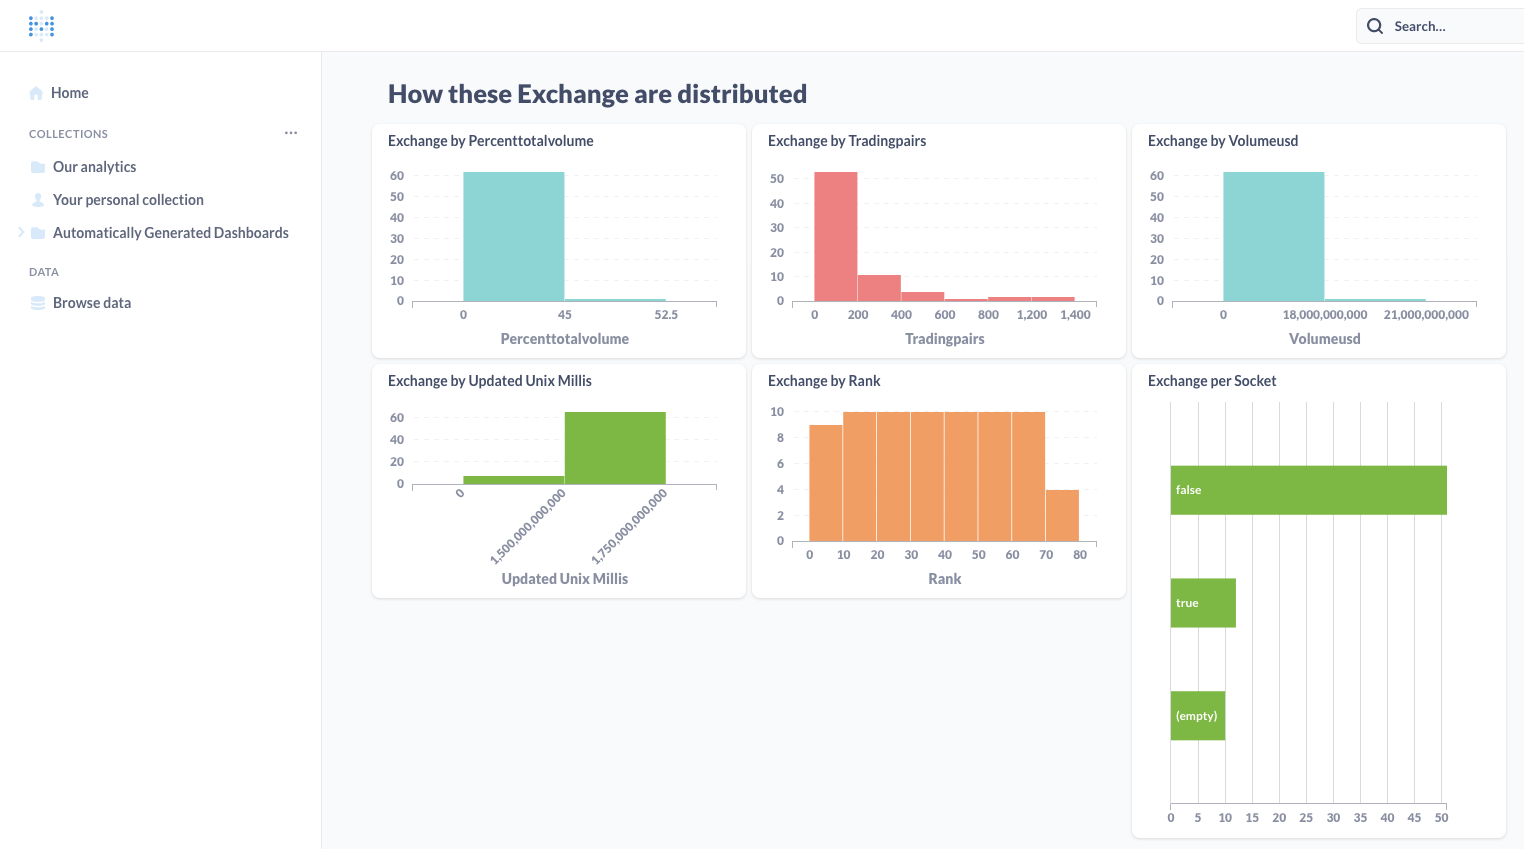

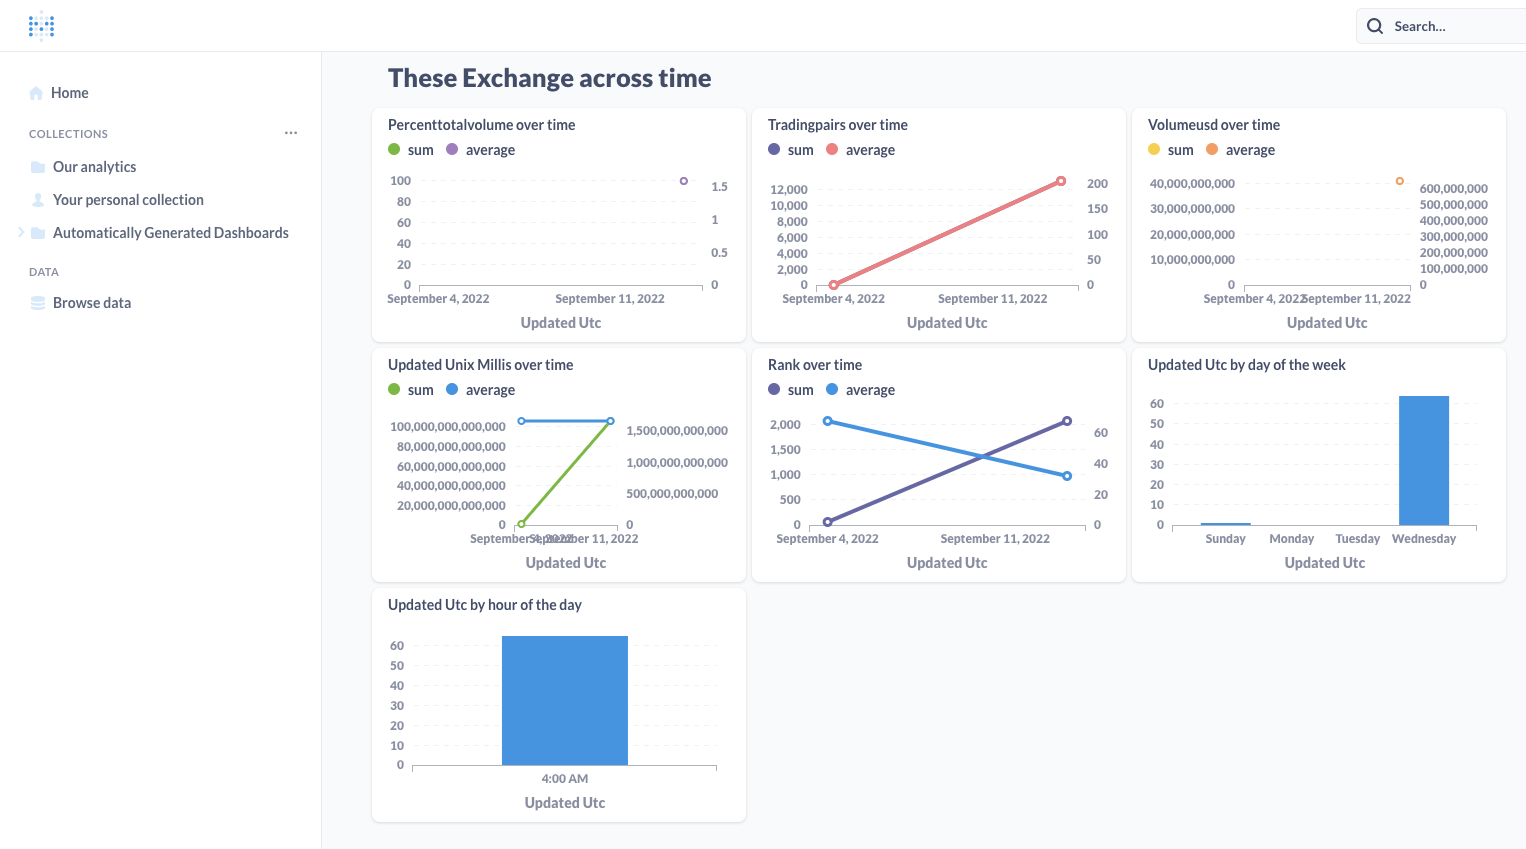

The remaining configs are available in the [env](env) file.

To tear down the local containers you can use:
```bash
make down
```

## Deploy to Production

Now that we have the code working locally, it’s time to deploy to production. We will run our data pipeline and dashboards as containers on an EC2 instance. We have helper scripts in [deploy_helpers](deploy_helpers) for this.  The first step is to start an EC2 ubuntu instance.

In EC2, we create an instance. A t2.micro instance should suffice (if you plan to keep your ETL job running indefinitely, you might need a bigger machine).

In the security group section, add a TCP rule, on port 3000 that accepts inbound connections from any `0.0.0.0/0` address.

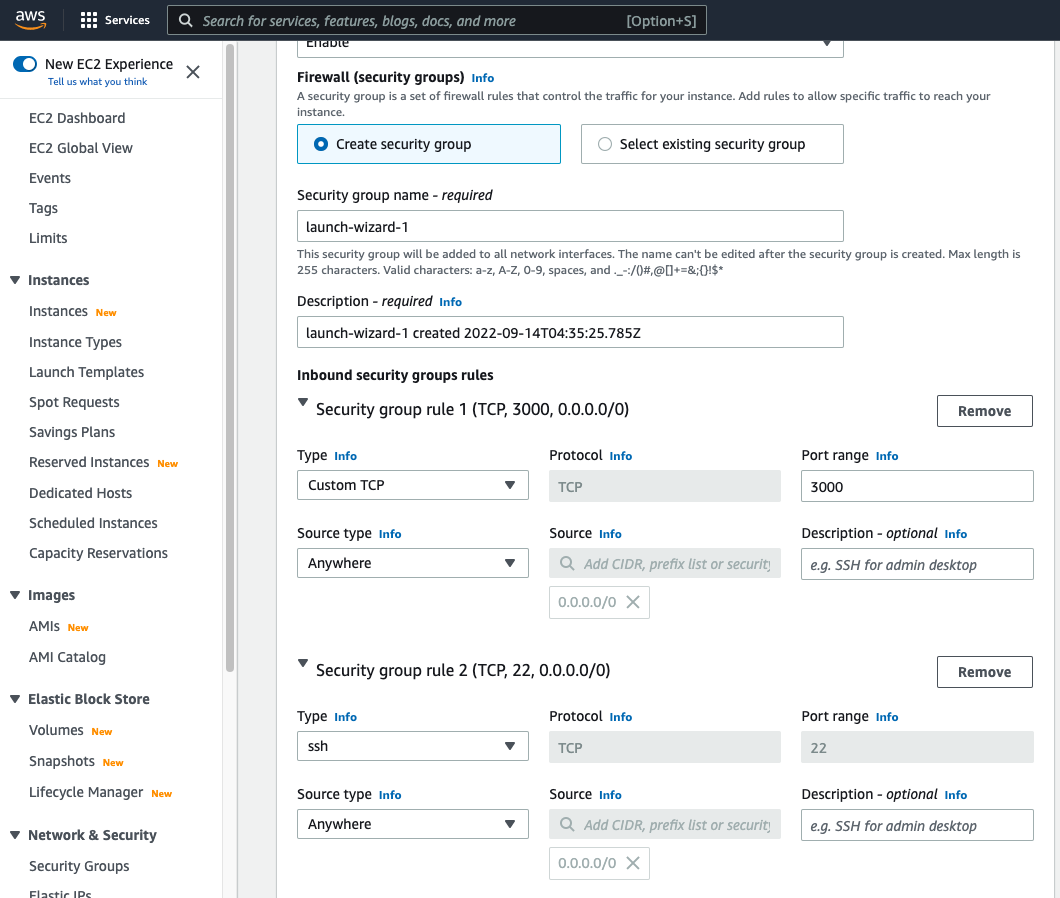

Wait for the EC2 instance to be in a ready state with all the checks passed. Then note down its `public DNS` and `public IPV4` addresses.

Now that you have a running EC2 instance, you can set up a prod instance as shown below.

1. Deploy your code to EC2, as shown:
```bash
chmod 755 ./deploy_helpers/send_code_to_prod.sh
chmod 400 your-pem-file-full-location
./deploy_helpers/send_code_to_prod.sh your-pem-file-full-location your-EC2-Public-DNS
# this will open up a bash to your remote EC2 instance
# If you are having trouble connecting use method 2 from https://aws.amazon.com/premiumsupport/knowledge-center/ec2-linux-fix-permission-denied-errors/
# you will be logged into your EC2 instance
```

2. Install docker and start your ETL and dashboard containers on EC2.
```bash
chmod 755 install_docker.sh
./install_docker.sh
# verify that docker and docker compose installed
docker --version
docker-compose --version
# start the containers
unzip bitcoinmonitor.gzip && cd bitcoin-monitor-project/
docker-compose --env-file env up --build -d
```

You can log into your remote Metabase instance by using `http://your-public-ipv4-address:3000`. From Metabase, you can set up a connection to the Postgres warehouse with the following credentials:
```bash
Host: warehouse
Database name: finance
```

A sample visualization of the total volume USD for each exchange over time:

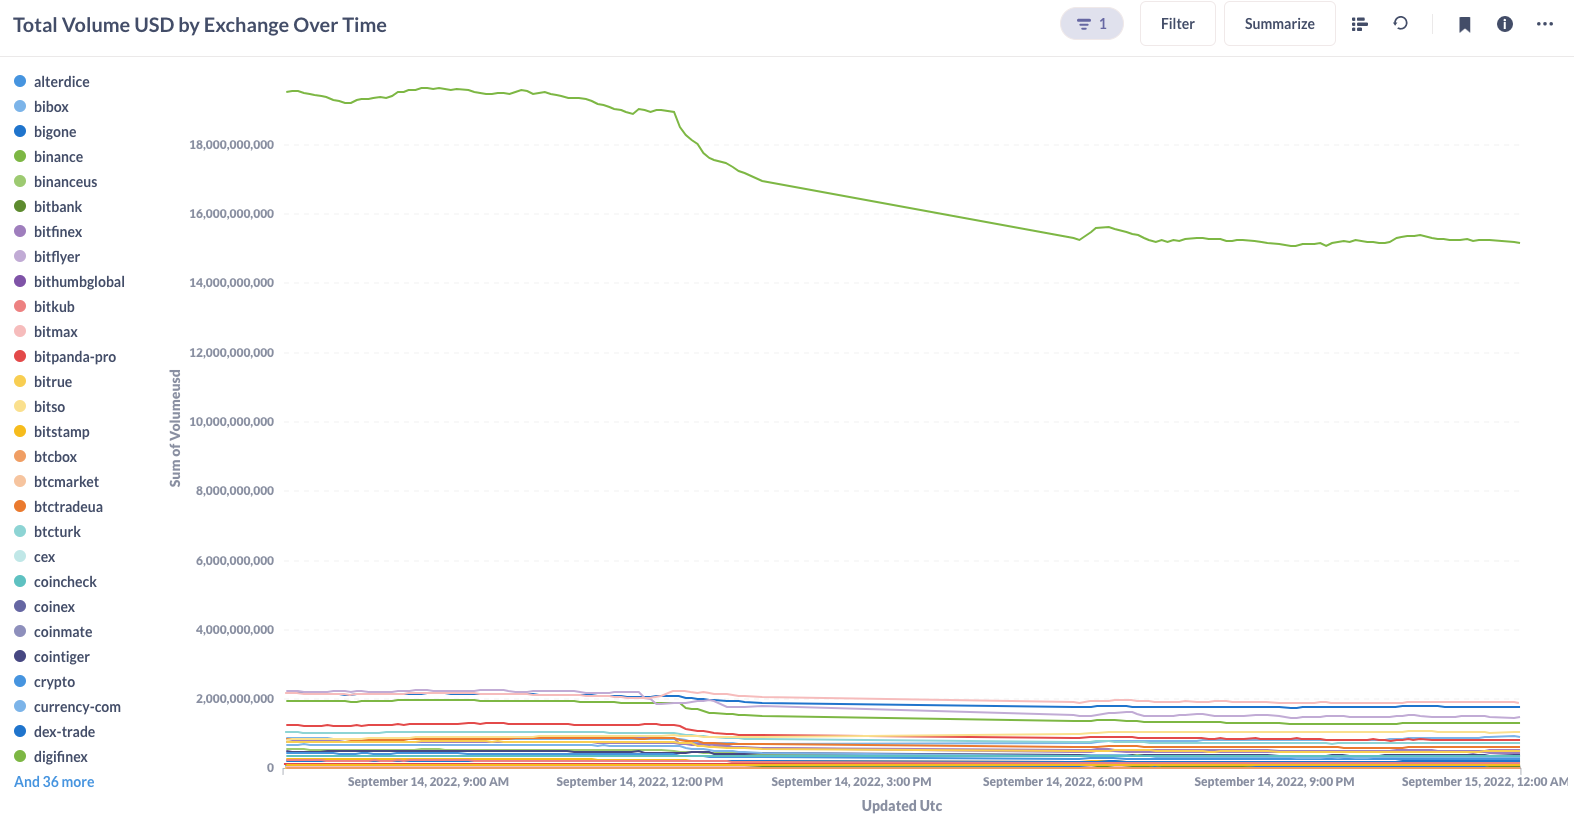

The remaining configs are available in the env file.

You can spin down your local instance with:
```bash
make down
```

Do not forget to turn off your EC2 instance.

### Resulting Dashboard

A sample dashboard using bitcoin exchange data is shown below:
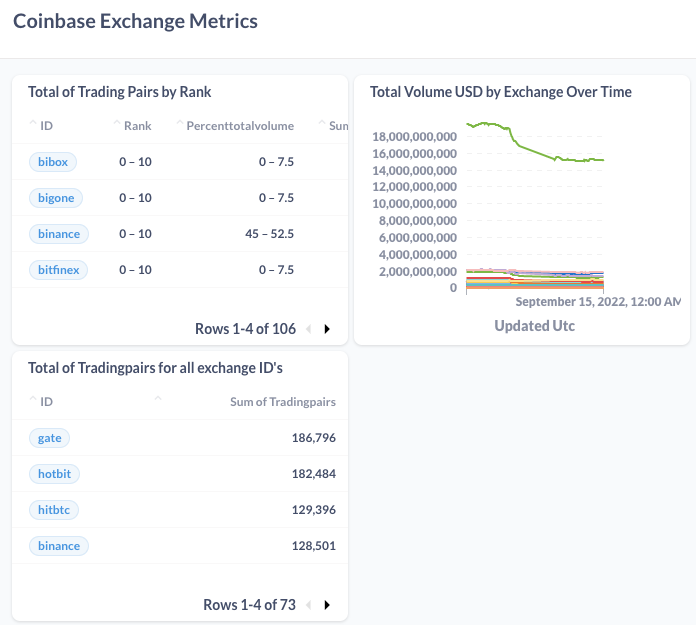

The public link to this dashboard is here: http://54.167.76.223:3000/public/dashboard/f7558e64-5200-42df-9975-6b3c74ced68a

Depending on the EC2 instance type you choose you may incur some cost. Use [AWS cost calculator](https://calculator.aws/#/) to figure out the cost.

In [1]:
#### Export of Jupyter notebook
!jupyter nbconvert README-bitcoin-monitor-project.ipynb --to html --template classic

[NbConvertApp] Converting notebook README-bitcoin-monitor-project.ipynb to html
[NbConvertApp] Writing 1015460 bytes to README-bitcoin-monitor-project.html
